<a href="https://colab.research.google.com/github/hanbo2000/NODEs---capstone/blob/main/Two-equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch   0 | loss = 0.042781 | H_curr = 1
Epoch 200 | loss = 0.046040 | H_curr = 3
Epoch 400 | loss = 0.045527 | H_curr = 5
Epoch 600 | loss = 0.038809 | H_curr = 7
Epoch 800 | loss = 0.035202 | H_curr = 9
Epoch 1000 | loss = 0.035107 | H_curr = 11


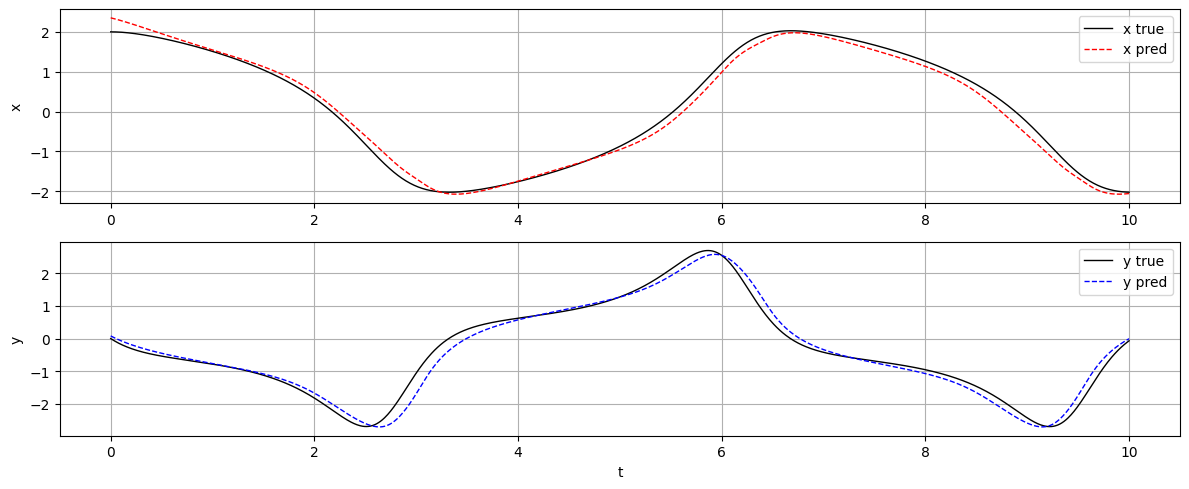

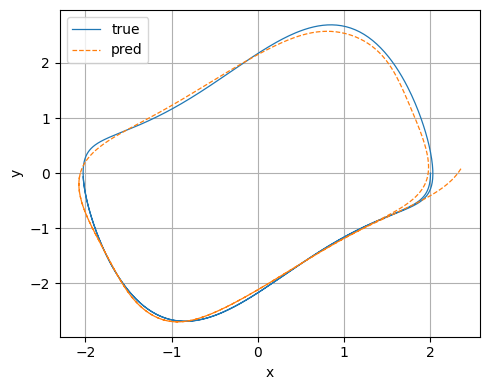

In [ ]:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----- Data / sampling -----
T = 10.0            # total duration [s]
DT = 0.01           # integration time step [s]
OBS_DT = 0.05       # observation interval [s]
NOISE_STD = 0.2     # std of Gaussian observation noise
SEED = 0            # random seed (reproducibility)

# ----- Model / optimization -----
HIDDEN = 128        # MLP hidden size
LR = 3e-4           # learning rate (AdamW)
WD = 1e-6           # weight decay (L2 regularization)
BATCH = 1024        # batch size
EPOCHS = 1200       # number of training epochs
H_MAX = 12          # max prediction horizon in curriculum (# of OBS_DT steps)


torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
torch.set_default_dtype(dtype)

mu_vdp = 1.0
def vdp_true(u, t):
    x, y = u
    return np.array([y, mu_vdp*(1.0 - x*x)*y - x], dtype=np.float32)

def euler_step_true(f, u, t, h):
    return u + h * f(u, t)

N = int(T/DT) + 1
t_full = np.linspace(0.0, T, N).astype(np.float32)
u0 = np.array([2.0, 0.0], dtype=np.float32)

U_true = np.zeros((N, 2), dtype=np.float32)
U_true[0] = u0
for i in range(N-1):
    U_true[i+1] = euler_step_true(vdp_true, U_true[i], t_full[i], DT)

U_noisy = U_true + np.random.normal(0, NOISE_STD, size=U_true.shape).astype(np.float32)

obs_stride = int(round(OBS_DT / DT))
assert obs_stride >= 1 and abs(obs_stride*DT - OBS_DT) < 1e-9
obs_idx = np.arange(0, N, obs_stride)
t_obs = t_full[obs_idx]
Y_obs = U_noisy[obs_idx]  # (M,2)

# standardization
mu = torch.tensor(U_true.mean(axis=0), device=device)
std = torch.tensor(U_true.std(axis=0) + 1e-8, device=device)

def norm_np(arr): return (arr - mu.cpu().numpy()) / std.cpu().numpy()
def denorm_t(tensor): return tensor * std + mu

Y_obs_std = norm_np(Y_obs)

w_obs = torch.tensor(Y_obs_std, device=device)
t_rel = torch.tensor(t_obs - t_obs[0], device=device)
obs_ofs = torch.tensor(obs_idx - obs_idx[0], device=device, dtype=torch.long)
M_obs = len(obs_idx)

n_sub = int(round(OBS_DT / DT))    # The number of fine steps in each observation interval
assert n_sub >= 1

# f_theta(y)->dy
class ODEFunc(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 2)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                nn.init.zeros_(m.bias)
    def forward(self, y, t=None):
        return self.net(y)

@torch.no_grad()
def euler_full_net(f, y0, t_seq):
    y_list = [y0]
    y = y0
    for i in range(len(t_seq)-1):
        h = (t_seq[i+1] - t_seq[i]).to(y.dtype).to(y.device).view(1,1)
        dy = f(y)
        y = y + dy * h
        y_list.append(y)
    return torch.cat(y_list, dim=0)

def euler_steps_batched_net(f, y0_batch, steps_batch, h):

    B = y0_batch.shape[0]
    y = y0_batch
    max_steps = int(steps_batch.max().item())
    h = torch.as_tensor(h, device=y.device, dtype=y.dtype).view(1,1)
    for s in range(max_steps):
        mask = (steps_batch > s).view(B,1)
        if not mask.any(): break
        dy = f(y)
        y = y + dy * h * mask
    return y

model = ODEFunc(hidden=HIDDEN).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.SmoothL1Loss(beta=0.5, reduction='mean')

weight = torch.ones(1,2, device=device)

for ep in range(EPOCHS):
    opt.zero_grad()

    H_curr = min(H_MAX, 1 + ep // 100)

    k_batch = torch.randint(0, M_obs-1, (BATCH,), device=device)
    h_batch = torch.randint(1, H_curr+1, (BATCH,), device=device)
    h_batch = torch.minimum(h_batch, (M_obs-1 - k_batch))

    y0_batch    = w_obs[k_batch]
    y_tar_batch = w_obs[k_batch + h_batch]
    steps_batch = h_batch * n_sub

    y_pred = euler_steps_batched_net(model, y0_batch, steps_batch, DT)

    diff = (y_pred - y_tar_batch) * weight
    loss = loss_fn(diff, torch.zeros_like(diff))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 200 == 0:
        print(f"Epoch {ep:3d} | loss = {loss.item():.6f} | H_curr = {H_curr}")

with torch.no_grad():
    y0 = w_obs[0:1, :]
    t_seq_std = torch.tensor(t_full, device=device).view(-1,1)
    y_pred_std = euler_full_net(model, y0, t_seq_std)
    Y_pred = denorm_t(y_pred_std.cpu()).numpy()
    Y_true = U_true
    t_plot = t_full

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(t_plot, Y_true[:,0], 'k-', lw=1.0, label='x true')
plt.plot(t_plot, Y_pred[:,0], 'r--', lw=1.0, label='x pred')
plt.ylabel('x'); plt.legend(); plt.grid(True)
plt.subplot(2,1,2)
plt.plot(t_plot, Y_true[:,1], 'k-', lw=1.0, label='y true')
plt.plot(t_plot, Y_pred[:,1], 'b--', lw=1.0, label='y pred')
plt.xlabel('t'); plt.ylabel('y'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(Y_true[:,0], Y_true[:,1], lw=0.9, label='true')
plt.plot(Y_pred[:,0], Y_pred[:,1], '--', lw=0.9, label='pred')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


Epoch   0 | loss = 0.377028 | H_curr = 3
Epoch 200 | loss = 0.367542 | H_curr = 5
Epoch 400 | loss = 0.345415 | H_curr = 7
Epoch 600 | loss = 0.285355 | H_curr = 9
Epoch 800 | loss = 0.249042 | H_curr = 11
Epoch 1000 | loss = 0.147106 | H_curr = 13


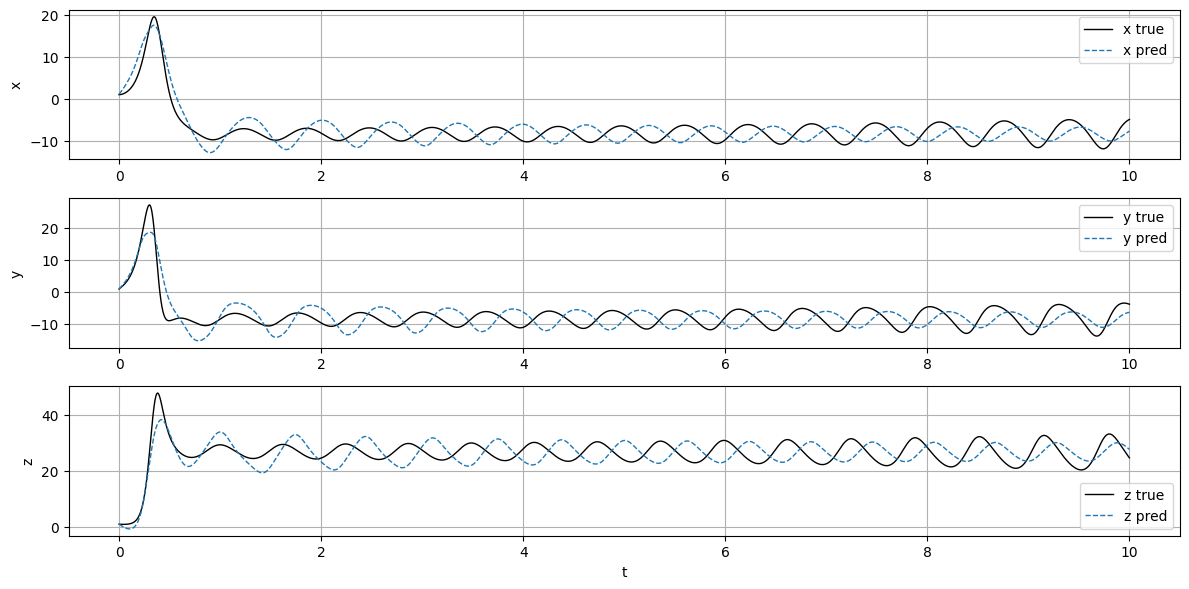

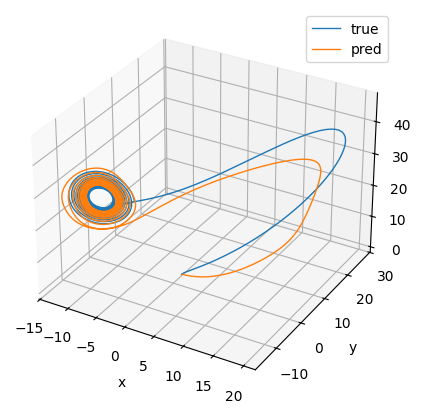

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----- Data / sampling -----
T = 10.0
DT = 0.005
OBS_DT = 0.025
NOISE_STD = 0.05
SEED = 0

# ----- Model / optimization -----
HIDDEN = 128
LR = 3e-4
WD = 1e-6
BATCH = 1024
EPOCHS = 1200
H_MAX = 20

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
torch.set_default_dtype(dtype)

# ==== Lorenz System Definition using RK4 ====
def f_np(u, s, b, r):
    x, y, z = u
    return np.array([
        s * (y - x),
        x * (r - z) - y,
        x * y - b * z
    ], dtype=np.float32)

def rk4_np(f, u0, t, dt, *args):
    U = np.zeros((len(t), 3), dtype=np.float32)
    U[0] = u0
    u = u0.copy()
    for i in range(len(t) - 1):
        k1 = f(u, *args)
        k2 = f(u + 0.5 * dt * k1, *args)
        k3 = f(u + 0.5 * dt * k2, *args)
        k4 = f(u + dt * k3, *args)
        u = u + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        U[i+1] = u
    return U

# ==== Generate True & Noisy Data ====
SIGMA_T = 10.0
BETA_T = 8.0 / 3.0
RHO_T = 28.0
u0 = np.array([1.0, 1.0, 1.0], dtype=np.float32)
N = int(T/DT) + 1
t_full = np.linspace(0.0, T, N).astype(np.float32)
U_true = rk4_np(f_np, u0, t_full, DT, SIGMA_T, BETA_T, RHO_T)

U_noisy = U_true + np.random.normal(0, NOISE_STD, size=U_true.shape).astype(np.float32)

obs_stride = int(round(OBS_DT / DT))
obs_idx = np.arange(0, N, obs_stride)
t_obs = t_full[obs_idx]
Y_obs = U_noisy[obs_idx]

# ==== Standardization ====
mu = torch.tensor(U_true.mean(axis=0), device=device)
std = torch.tensor(U_true.std(axis=0) + 1e-8, device=device)

def norm_np(arr): return (arr - mu.cpu().numpy()) / std.cpu().numpy()
def denorm_t(tensor): return tensor * std + mu

Y_obs_std = norm_np(Y_obs)
w_obs = torch.tensor(Y_obs_std, device=device)
t_rel = torch.tensor(t_obs - t_obs[0], device=device)
obs_ofs = torch.tensor(obs_idx - obs_idx[0], device=device, dtype=torch.long)
M_obs = len(obs_idx)

n_sub = int(round(OBS_DT / DT))
assert n_sub >= 1

# ==== Neural ODE Model ====
class ODEFunc(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 3)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.zeros_(m.bias)

    def forward(self, y, t=None):
        return self.net(y)

@torch.no_grad()
def rk4_full_net(f, y0, t_seq):
    y_list = [y0]
    y = y0
    for i in range(len(t_seq) - 1):
        h = (t_seq[i+1] - t_seq[i]).to(y.dtype).to(y.device).view(1,1)
        k1 = f(y)
        k2 = f(y + 0.5 * h * k1)
        k3 = f(y + 0.5 * h * k2)
        k4 = f(y + h * k3)
        y = y + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        y_list.append(y)
    return torch.cat(y_list, dim=0)

def rk4_steps_batched_net(f, y0_batch, steps_batch, h):
    B = y0_batch.shape[0]
    y = y0_batch
    max_steps = int(steps_batch.max().item())
    h_tensor = torch.tensor(h, device=y.device, dtype=y.dtype).view(1, 1)
    for s in range(max_steps):
        mask = (steps_batch > s).view(B, 1)
        if not mask.any():
            break
        k1 = f(y)
        k2 = f(y + 0.5 * h_tensor * k1)
        k3 = f(y + 0.5 * h_tensor * k2)
        k4 = f(y + h_tensor * k3)
        dy = (1.0 / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        y = y + h_tensor * dy * mask
    return y

# ==== Training ====
model = ODEFunc(hidden=HIDDEN).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.MSELoss(reduction='mean')

weight = torch.tensor([[1.0, 1.0, 2.0]], device=device)


for ep in range(EPOCHS):
    opt.zero_grad()
    H_curr = min(H_MAX, 3 + ep // 100)

    k_batch = torch.randint(0, M_obs - H_curr - 1, (BATCH,), device=device)
    h_batch = torch.randint(1, H_curr + 1, (BATCH,), device=device)
    h_batch = torch.minimum(h_batch, (M_obs - 1 - k_batch))

    y0_batch = w_obs[k_batch]
    y_tar_batch = w_obs[k_batch + h_batch]
    steps_batch = h_batch * n_sub

    y_pred = rk4_steps_batched_net(model, y0_batch, steps_batch, DT)
    diff = (y_pred - y_tar_batch) * weight
    loss = loss_fn(diff, torch.zeros_like(diff))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 200 == 0:
        print(f"Epoch {ep:3d} | loss = {loss.item():.6f} | H_curr = {H_curr}")

# ==== Inference ====
with torch.no_grad():
    y0 = w_obs[0:1, :]
    t_seq_std = torch.tensor(t_full, device=device).view(-1, 1)
    y_pred_std = rk4_full_net(model, y0, t_seq_std)
    Y_pred = denorm_t(y_pred_std.cpu()).numpy()
    Y_true = U_true
    t_plot = t_full

# ==== Visualization ====
plt.figure(figsize=(12, 6))
for i, label in enumerate(['x', 'y', 'z']):
    plt.subplot(3, 1, i+1)
    plt.plot(t_plot, Y_true[:, i], 'k-', lw=1.0, label=f'{label} true')
    plt.plot(t_plot, Y_pred[:, i], '--', lw=1.0, label=f'{label} pred')
    plt.ylabel(label); plt.grid(True); plt.legend()
plt.xlabel('t')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6, 5))
ax = plt.axes(projection='3d')
ax.plot3D(Y_true[:, 0], Y_true[:, 1], Y_true[:, 2], label='true', lw=1)
ax.plot3D(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2], label='pred', lw=1)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.legend(); plt.show()
